In [24]:
 !pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\fedeb\desktop\datos\workspace\venv\lib\site-packages (0.24.1)


You should consider upgrading via the 'c:\users\fedeb\desktop\datos\workspace\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger

In [26]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

In [27]:
# train['Week_Day'].describe()

# TP2 - XGBoost Binary Classifier


Luego verifico que dropear filas que se overlapean con test implica
dejar de lado la mayoria de datos por lo cual no se tendraa en cuenta.
(djo el codigo de dropeo comentaado)

-----------------------------------------


# Seteo de features

In [28]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("Opportunity_ID")

#VANILLA NO
# features.remove("delivery_delay")
# features.remove("opportunity_lifetime")
# features.remove("converted_taxable_amount")
# features.remove("last_modified_to_delivery")
# features.remove("currency_conversion_rate")
# features.remove("Occur")
# features.remove("delivery_window")
# features.remove("account_creation_to_created_opp")

#VANILLA SI
features.remove('Total_Taxable_Amount')
features.remove('ASP_(converted)')
features.remove("ASP")
features.remove("Total_Amount")
features.remove("Delivery_Year")
# features.remove("Week_Day")

#CONSIDERO REMOVIBLES
features.remove("created_blocknum")   #FECHA!!
features.remove("late_delivery_blocknum")
features.remove("early_delivery_blocknum")
features.remove("last_modified_blocknum")
features.remove("account_creation_blocknum") #OJO CCON HIPOTESIS DEL CLIENTE VIEEJO
print("Features totales: {}".format(len(features)))



Features totales: 118


# Armado de sets
FORMAS:

In [29]:
X_train, y_train = train.loc[:,features], train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]

print("Set de entrenamiento (size) {}".format(X_train.shape))
print("Set de testing (size) {}".format(X_test.shape))

Set de entrenamiento (size) (16947, 118)
Set de testing (size) (2551, 118)


Por otra parte seepaaro el test de entrenamiento en aprox~(80%/20%) segun la fecha de creeacion de la oportunidad.

In [30]:
percent_80 = train["created_blocknum"].describe()['75%']/0.945
beta_test = train[train["created_blocknum"]>percent_80]
beta_train = train[train["created_blocknum"]<percent_80]


In [31]:
A_train, b_train = beta_train.loc[:,features], beta_train.loc[:,target]
# A_test_Opp = beta_test.loc[:,"Opportunity_ID"]
A_test, b_test = beta_test.loc[:,features], beta_test.loc[:,target]

print("Set de entrenamiento secundario (size) {}".format(A_train.shape))
print("Set de testing secundario (size) {}".format(A_test.shape))

Set de entrenamiento secundario (size) (14078, 118)
Set de testing secundario (size) (2869, 118)


In [32]:

dtrain = xgb.DMatrix(X_train, label=y_train)



# Tuneo de hiperparametros
* GRIDSEARCH + CROSS VALIDATION

Configuracion

In [33]:
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#----------------------------- C O N F I G U R A C I O N ----------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

nfolds = 5
rounds = 200
boost_rounds = 150
early_stopping_rounds = 6

params = {"objective": "binary:logistic",
          'colsample_bytree': 0.3,
          'subsample': 1.0,
          'learning_rate': 0.1,
          'max_depth': 6,
          'min_child_weight': 1,
          'eval_metric': 'logloss'}
beta_params = params.copy()
beta_params['n_estimators'] = 100


enaable_gridsearch_for_tree = True
enaable_gridsearch_for_sampling = True
enaable_gridsearch_for_learning = True
final_cv = False
enable_parcial_training = True

print("Usando nfolds={},  num_boost_round={}"
      "  y  early_stopping_rounds={}".format(nfolds, rounds, early_stopping_rounds))

#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

Usando nfolds=5,  num_boost_round=200  y  early_stopping_rounds=6


In [34]:
#FUNCIONES

def find_best_param_tuple(dtrain, params, param_tuple):
    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for param0, param1 in param_tuple['grid']:
        print("CV with {}={}, {}={}".format(param_tuple['names'][0],
                                 param0,
                                 param_tuple['names'][1],
                                 param1))
        # Update our parameters
        params[param_tuple['names'][0]] = param0
        if param_tuple['names'][1]: params[param_tuple['names'][1]] = param1
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=1234,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        current_boost_rounds = cv_results['test-logloss-mean'].argmin()+1
        print("\tLL {} for {} rounds".format(mean_logloss, current_boost_rounds))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (param0, param1)
            global boost_rounds
            boost_rounds = current_boost_rounds
    print("Best {},{}: {}, {}, LogLoss: {}".format(param_tuple['names'][0],param_tuple['names'][1],best_params[0], best_params[1], min_logloss))
    return best_params

TUNEO DE:
* max_depth
* min_child_weight

In [35]:
if enaable_gridsearch_for_tree:

    tree_params_tuple = {
        'names': ('max_depth', 'min_child_weight'),
        'grid': [
            (max_depth, min_child_weight)
            for max_depth in range(1,20,2)
            for min_child_weight in range(1,3)
        ]
    }

    best_tree_params = find_best_param_tuple(dtrain, params, tree_params_tuple)

    params['max_depth'] = best_tree_params[0]
    params['min_child_weight'] = best_tree_params[1]

CV with max_depth=1, min_child_weight=1
	LL 0.3819202 for 200 rounds
CV with max_depth=1, min_child_weight=2
	LL 0.3819202 for 200 rounds
CV with max_depth=3, min_child_weight=1
	LL 0.2795528 for 200 rounds
CV with max_depth=3, min_child_weight=2
	LL 0.28094080000000005 for 200 rounds
CV with max_depth=5, min_child_weight=1
	LL 0.218913 for 200 rounds
CV with max_depth=5, min_child_weight=2
	LL 0.22093639999999998 for 200 rounds
CV with max_depth=7, min_child_weight=1
	LL 0.17950660000000002 for 200 rounds
CV with max_depth=7, min_child_weight=2
	LL 0.1801084 for 200 rounds
CV with max_depth=9, min_child_weight=1
	LL 0.1614202 for 200 rounds
CV with max_depth=9, min_child_weight=2
	LL 0.1648634 for 200 rounds
CV with max_depth=11, min_child_weight=1
	LL 0.16047640000000002 for 159 rounds
CV with max_depth=11, min_child_weight=2
	LL 0.16097319999999998 for 194 rounds
CV with max_depth=13, min_child_weight=1
	LL 0.15972219999999998 for 143 rounds
CV with max_depth=13, min_child_weight=2


TUNEO DE:
* subsamble
* colsample_bytree


In [36]:
if enaable_gridsearch_for_sampling:

    sample_params_tuple = {
        'names': ('subsample', 'colsample_bytree'),
        'grid': [
            (subsample, colsample_bytree)
            for subsample in [i/10. for i in range(7,11)]
            for colsample_bytree in  [i/10. for i in range(2,5)]
        ]
    }

    best_sample_params = find_best_param_tuple(dtrain, params, sample_params_tuple)

    params['subsample'] = best_sample_params[0]
    params['colsample_bytree'] = best_sample_params[1]

CV with subsample=0.7, colsample_bytree=0.2
	LL 0.163076 for 199 rounds
CV with subsample=0.7, colsample_bytree=0.3
	LL 0.1635182 for 177 rounds
CV with subsample=0.7, colsample_bytree=0.4
	LL 0.16362839999999998 for 152 rounds
CV with subsample=0.8, colsample_bytree=0.2
	LL 0.1616458 for 198 rounds
CV with subsample=0.8, colsample_bytree=0.3
	LL 0.1612818 for 177 rounds
CV with subsample=0.8, colsample_bytree=0.4
	LL 0.1640974 for 144 rounds
CV with subsample=0.9, colsample_bytree=0.2
	LL 0.1597428 for 194 rounds
CV with subsample=0.9, colsample_bytree=0.3
	LL 0.1622434 for 139 rounds
CV with subsample=0.9, colsample_bytree=0.4
	LL 0.1624476 for 135 rounds
CV with subsample=1.0, colsample_bytree=0.2
	LL 0.159211 for 160 rounds
CV with subsample=1.0, colsample_bytree=0.3
	LL 0.15972219999999998 for 143 rounds
CV with subsample=1.0, colsample_bytree=0.4
	LL 0.1627872 for 129 rounds
Best subsample,colsample_bytree: 1.0, 0.2, LogLoss: 0.159211


TUNEO DE:
* learning rate (eta)

In [37]:
if enaable_gridsearch_for_learning:
    learning_rate_grid = [
        (learning_rate, empty)
        for learning_rate in [i/100. for i in range(5,21)]
        for empty in range(1,2)
    ]
    learning_rate = {
        'names': ('learning_rate',''),
        'grid': learning_rate_grid,
    }
    params['learning_rate'] = find_best_param_tuple(dtrain, params, learning_rate)[0]

CV with learning_rate=0.05, =1
	LL 0.1648008 for 200 rounds
CV with learning_rate=0.06, =1
	LL 0.1613306 for 200 rounds
CV with learning_rate=0.07, =1
	LL 0.16036199999999998 for 199 rounds
CV with learning_rate=0.08, =1
	LL 0.15843780000000002 for 199 rounds
CV with learning_rate=0.09, =1
	LL 0.15794160000000002 for 194 rounds
CV with learning_rate=0.1, =1
	LL 0.159211 for 160 rounds
CV with learning_rate=0.11, =1
	LL 0.159447 for 160 rounds
CV with learning_rate=0.12, =1
	LL 0.1606618 for 160 rounds
CV with learning_rate=0.13, =1
	LL 0.1593064 for 158 rounds
CV with learning_rate=0.14, =1
	LL 0.1597858 for 142 rounds
CV with learning_rate=0.15, =1
	LL 0.161746 for 119 rounds
CV with learning_rate=0.16, =1
	LL 0.1623392 for 95 rounds
CV with learning_rate=0.17, =1
	LL 0.1627226 for 97 rounds
CV with learning_rate=0.18, =1
	LL 0.16487559999999998 for 94 rounds
CV with learning_rate=0.19, =1
	LL 0.1650168 for 104 rounds
CV with learning_rate=0.2, =1
	LL 0.1645142 for 93 rounds
Best lear

Final cross validation error

In [38]:
if final_cv:
    cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=1000,
                seed=1234,
                nfold=len(features),
                metrics='logloss',
                early_stopping_rounds=early_stopping_rounds
            )
    print("Rounds    LogLoss \n  {}.".format(cv_results["test-logloss-mean"].tail(1), cv_results["test-logloss-mean"].tail(1)))
    display(cv_results.tail(1))

# Entrenamiento

In [39]:
xgb_clf = xgb.XGBClassifier(objective ='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            colsample_bytree = params['colsample_bytree'],
            subsample = params['subsample'],
            learning_rate = params['learning_rate'],
            max_depth = params['max_depth'],
            n_estimators = boost_rounds,
            reg_alpha=0,
            min_child_weight = params['min_child_weight'])


xgb_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=13, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=194, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [40]:
preds = [pred[1] for pred in xgb_clf.predict_proba(X_test)]
# preds

# ENTRENAMIENTO PARCIAL
CALCULO DE ERROR EN BASE A PARTICION DE SET DE ENTRENAMIENTO POR FECHA DE CREACION DE LA OPORTUNIDAD

In [41]:
def partial_tune(params, params_to_tune):
    min_logloss = float("Inf")
    max_accuracy = -float("Inf")
    best_params = None
    for param0, param1 in params_to_tune['range']:
        print("{}={}, {}={}".format(params_to_tune['names'][0],
                                    param0,
                                    params_to_tune['names'][1],
                                    param1))
        # Update our parameters
        params[params_to_tune['names'][0]] = param0
        params[params_to_tune['names'][1]] = param1
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = int(params['max_depth']),
                    n_estimators = params['n_estimators'],
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))

        predictions = [round(value) for value in beta_preds]
        accuracy = accuracy_score(b_test, predictions)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))

        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (param0, param1)
        if max_accuracy < accuracy:
            max_accuracy = accuracy
            best_acu_params = (param0, param1)
    print("Best {}: ({}, {}) with LogLoss: {}".format(params_to_tune['names'], best_params[0], best_params[1], min_logloss))
    print("Best {}: ({}, {}) with Accu: {}".format(params_to_tune['names'], best_acu_params[0], best_acu_params[1], max_accuracy))
    return best_params

#-----------------------------------
#-----------------------------------
#-----------------------------------

if enable_parcial_training:

    print("\n TUNEANDO alpha \n")
    aplha_range = [
        (alpha, n_estimator)
        for alpha in range(0,11,2)
        for n_estimator in range(1,2)
    ]
    best_alpha = partial_tune(beta_params, {'names':('alpha',''),'range':aplha_range})
    beta_params['alpha'] = best_alpha[0]
    # beta_params['n_estimators'] = best_alpha[1]


    print("\n TUNEANDO learning_rate \n")
    learning_rate_range = [
        (learning_rate, empty)
        for learning_rate in [i/100. for i in range(8,21)]
        for empty in range(1,2)
    ]
    best_learning_rate = partial_tune(beta_params, {'names':('learning_rate',''),'range':learning_rate_range})
    beta_params['learning_rate'] = best_learning_rate[0]


    print("\n TUNEANDO TREE_PARAMS \n")
    tree_params_range = [
        (max_depth, min_child_weight)
        for max_depth in range(5,9)
        for min_child_weight in range(1,5)
    ]
    best_tree_params = partial_tune(beta_params, {'names':('max_depth','min_child_weight'),'range':tree_params_range})
    beta_params['max_depth'] = int(best_tree_params[0])
    beta_params['min_child_weight'] = int(best_tree_params[1])


    print("\n TUNEANDO sample_params \n")
    sample_grid_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(6,11)]
        for colsample_bytree in  [i/10. for i in range(1,5)]
    ]
    best_sample_params = partial_tune(beta_params, {'names':('subsample','colsample_bytree'),'range':sample_grid_params})
    beta_params['subsample'] = best_sample_params[0]
    beta_params['colsample_bytree'] = best_sample_params[1]


    print("\n TUNEANDO n_estimators \n")
    n_estimator_range = [
        (n_estimator, empty)
        for n_estimator in range(50,160,10)
        for empty in range(1,2)
    ]
    best_n_estimator = partial_tune(beta_params, {'names':('n_estimators',''),'range':n_estimator_range})
    beta_params['n_estimators'] = best_n_estimator[0]



 TUNEANDO alpha 

alpha=0, =1
Log loss: 0.31444876742889355
Accuracy: 85.95%
alpha=2, =1
Log loss: 0.3172185015232887
Accuracy: 87.59%
alpha=4, =1
Log loss: 0.3237599646670375
Accuracy: 86.09%
alpha=6, =1
Log loss: 0.3293189082455225
Accuracy: 86.06%
alpha=8, =1
Log loss: 0.32703780434022955
Accuracy: 86.48%
alpha=10, =1
Log loss: 0.33211436617800383
Accuracy: 86.13%
Best ('alpha', ''): (0, 1) with LogLoss: 0.31444876742889355
Best ('alpha', ''): (2, 1) with Accu: 0.8759149529452771

 TUNEANDO learning_rate 

learning_rate=0.08, =1
Log loss: 0.31945489324615023
Accuracy: 87.00%
learning_rate=0.09, =1
Log loss: 0.31463750415561886
Accuracy: 86.16%
learning_rate=0.1, =1
Log loss: 0.31444876742889355
Accuracy: 85.95%
learning_rate=0.11, =1
Log loss: 0.3044624517678723
Accuracy: 86.58%
learning_rate=0.12, =1
Log loss: 0.3046906735508973
Accuracy: 86.55%
learning_rate=0.13, =1
Log loss: 0.31141608430389633
Accuracy: 86.51%
learning_rate=0.14, =1
Log loss: 0.3049383463925942
Accuracy: 86.34

In [42]:
beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic',
                                eval_metric='logloss',
                                use_label_encoder=False,
                                colsample_bytree = beta_params['colsample_bytree'],
                                subsample = beta_params['subsample'],
                                learning_rate = beta_params['learning_rate'],
                                max_depth = int(beta_params['max_depth']),
                                n_estimators = beta_params['n_estimators'],
                                reg_alpha=beta_params['alpha'],
                                min_child_weight = beta_params['min_child_weight'])
print(beta_xgb_clf)
beta_xgb_clf.fit(X_train,y_train)
beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(X_test)]
beta_pred_df = pd.DataFrame(X_test_Opp)
beta_pred_df["Target"] = beta_preds
beta_pred_df = beta_pred_df.drop_duplicates("Opportunity_ID")
beta_pred_df.to_csv("../submits/xgb-clf-tunned-beta.csv", index=False)
display(beta_pred_df)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.17, max_delta_step=None, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=0, reg_lambda=None,
              scale_pos_weight=None, subsample=1.0, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)


,Opportunity_ID,Target
0,10689,0.959861
3,10690,0.667463
8,10691,0.303459
9,10692,0.160393
15,10693,0.958142
...,...,...
2545,12364,0.968176
2547,12365,0.155730
2548,12366,0.149912
2549,12367,0.585143


Guardando las predicciones a CSV

In [43]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
display(pred_df)
pred_df.to_csv("../submits/xgb-clf-cv_tunned.csv",index=False)

,Opportunity_ID,Target
0,10689,0.961435
3,10690,0.866178
8,10691,0.522189
9,10692,0.246234
15,10693,0.990876
...,...,...
2545,12364,0.987839
2547,12365,0.351295
2548,12366,0.292341
2549,12367,0.876197


{'objective': 'binary:logistic', 'colsample_bytree': 0.2, 'subsample': 1.0, 'learning_rate': 0.09, 'max_depth': 13, 'min_child_weight': 1, 'eval_metric': 'logloss'}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

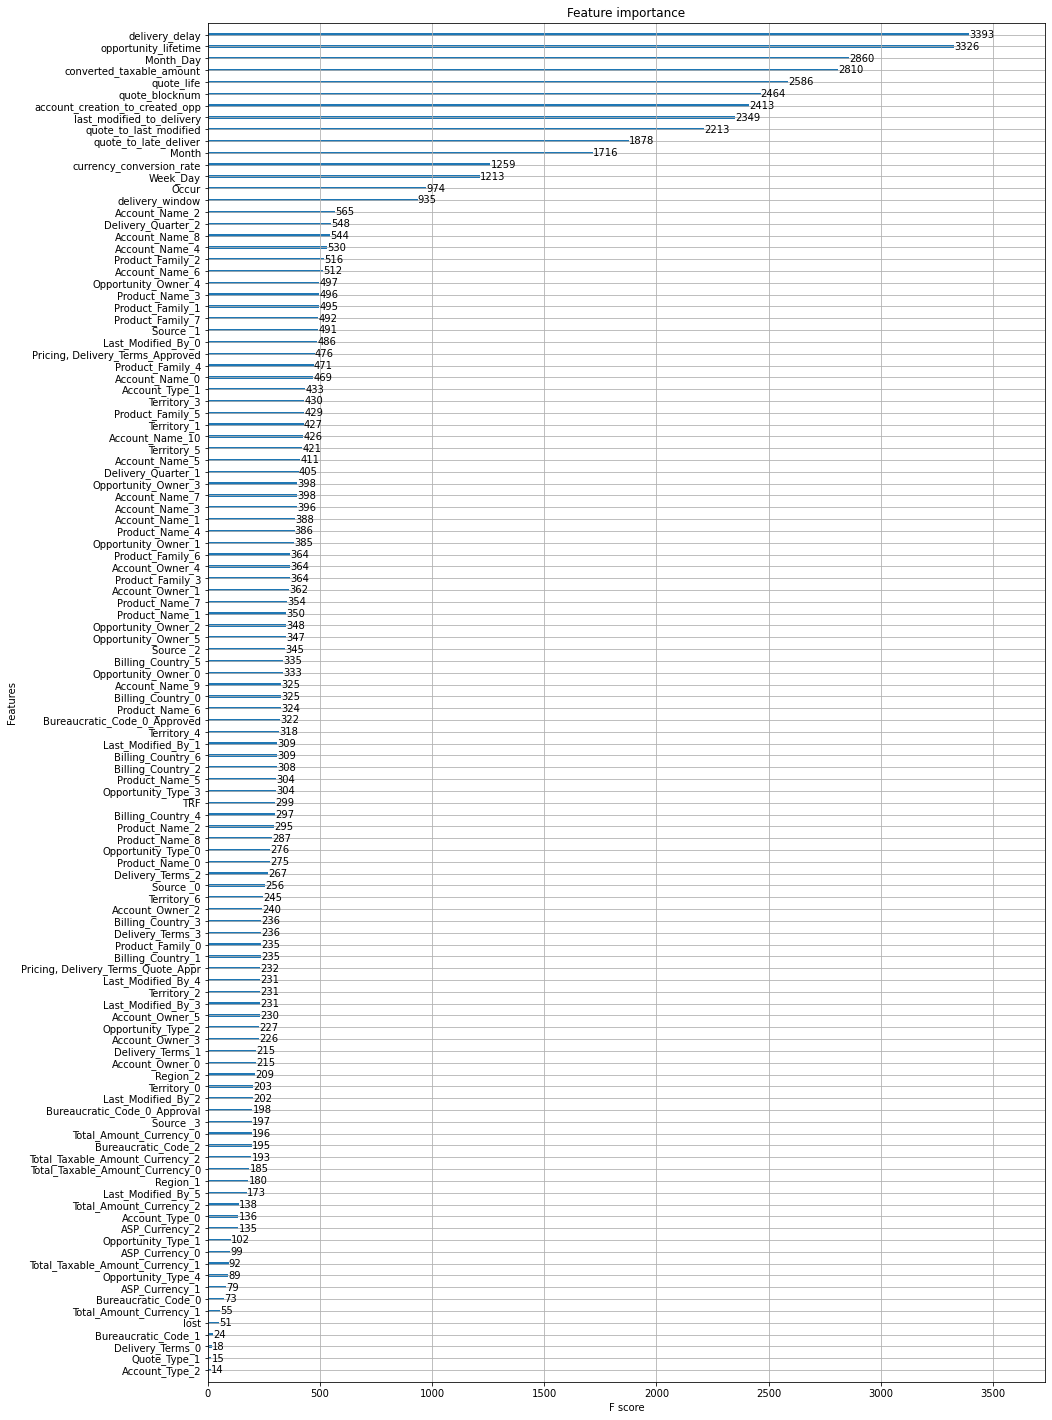

In [44]:
print(params)
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xgb_clf)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

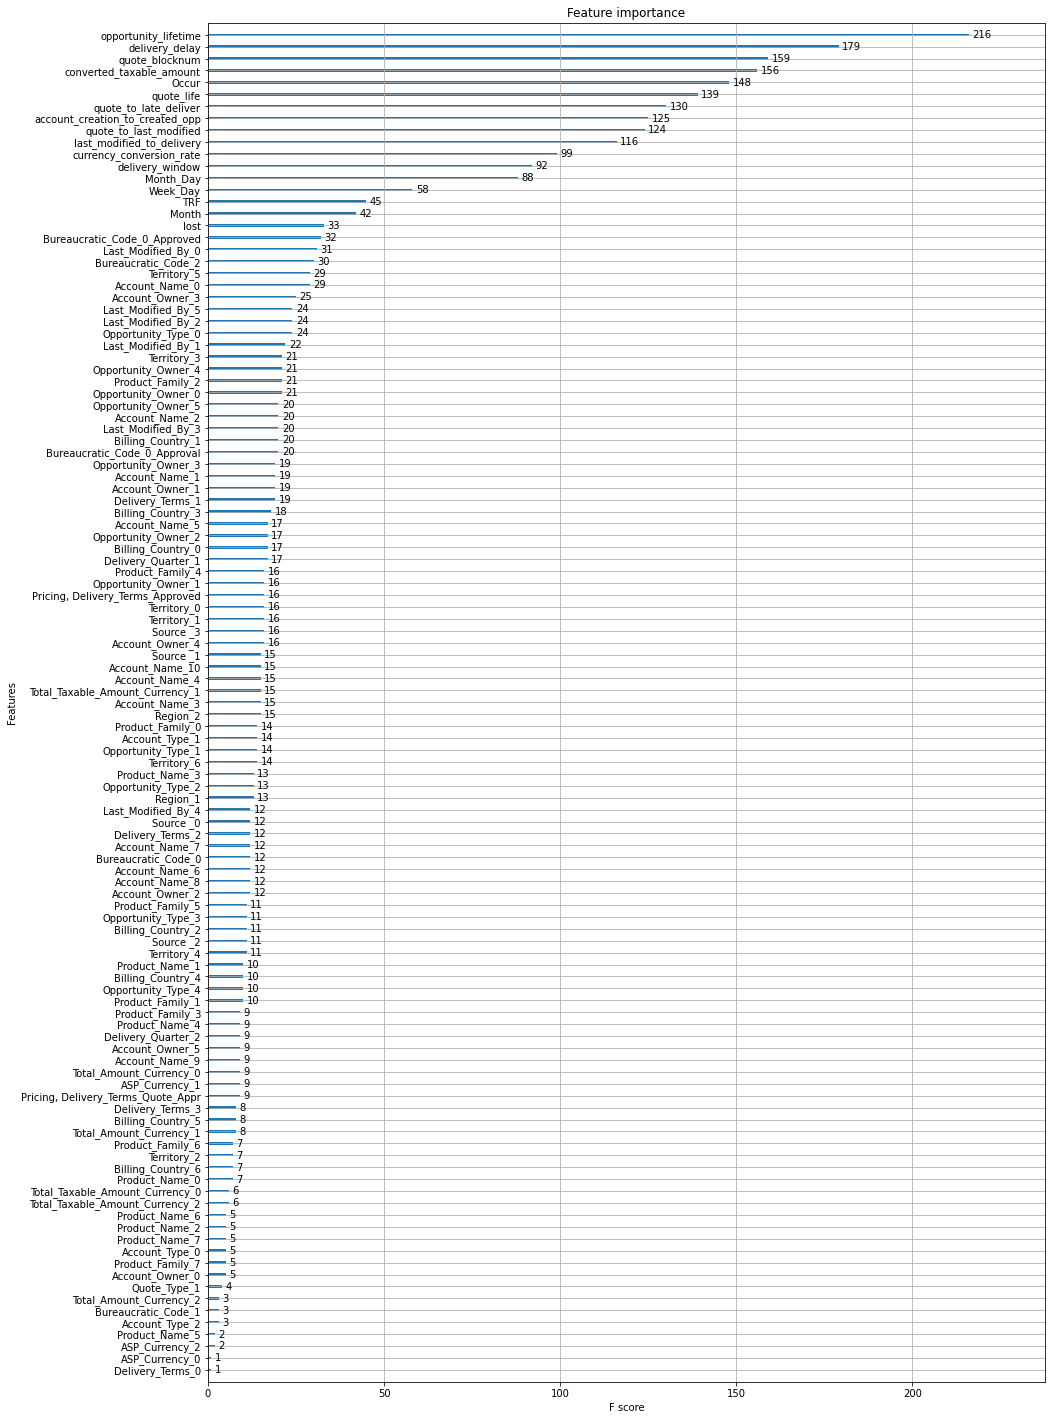

In [45]:
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(beta_xgb_clf)

In [46]:
# logger.Logger.log_model("xgb-logloss", params, features, cv_score)